In [1]:
import catboost as cat
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import multiprocessing


In [2]:
df = pd.read_csv( "../Training.csv" )

# Tratamiento del DF

In [3]:
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = df['Total_Amount']*0.0096
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = df['Total_Amount']*1.17
df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = df['Total_Amount']*0.70
df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = df['Total_Amount']*1.29
df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'
df.dropna(inplace = True)
df['Opportunity_Created_Date'] = pd.to_datetime(df['Opportunity_Created_Date'],errors='coerce')
df["Year Created"] = df["Opportunity_Created_Date"].dt.year
df["Month Created"] =df["Opportunity_Created_Date"].dt.month
df["Expensive"] = np.where(df["Total_Taxable_Amount"] >= 80000, 1, 0)
df['Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'],errors='coerce')
df['Planned_Delivery_End_Date'] = pd.to_datetime(df['Planned_Delivery_End_Date'],errors='coerce')
df = df[df["Total_Amount"] > 0]
df["Total_Amount"] = np.log(df["Total_Amount"])
entrenamiento_by_region = df.groupby("Region").agg({"Stage" : "count"})
entrenamiento_by_region.rename(columns = {"Stage" : "Amount of Cases"}, inplace = True)
entrenamiento_won_by_region = df[df["Stage"] == "Closed Won"].groupby("Region").agg({"Stage" : "count"})
entrenamiento_won_by_region.rename(columns = {"Stage" : "Cases won"}, inplace = True)

entrenamiento_won_by_region["percentage"] = (entrenamiento_won_by_region["Cases won"] / entrenamiento_by_region["Amount of Cases"]) * 100
df = df.merge(entrenamiento_won_by_region, on = "Region")
df["Años en entregar"] = df["Delivery_Year"] - df["Year Created"]

In [4]:
short_df = df[['Opportunity_ID', "Total_Amount", "Años en entregar","Month Created", "Product_Name", "Opportunity_Owner", 'Stage' ]].rename(columns={'Stage': 'Decision'})
short_df = short_df[ (short_df['Decision'] == 'Closed Won') | (short_df['Decision'] == 'Closed Lost') ]
short_df['Decision'] = np.where(short_df['Decision'] == 'Closed Won',1,0)
short_df.set_index('Opportunity_ID', inplace = True)


short_df.describe()
short_df.dropna(inplace = True)

## Mean Encoding

In [5]:
short_df["Product_Name"] = np.where(short_df.groupby('Product_Name')["Product_Name"].transform(len) > 5, short_df["Product_Name"], "Other")
mean_encoded_product = short_df.groupby("Product_Name")["Decision"].mean().to_dict()
short_df["Product_Name"] = short_df["Product_Name"].map(mean_encoded_product)

In [6]:
short_df["Opportunity_Owner"] = np.where(short_df.groupby('Opportunity_Owner')["Opportunity_Owner"].transform(len) > 5, short_df["Opportunity_Owner"], "Other")
mean_encoded_owner = short_df.groupby("Opportunity_Owner")["Decision"].mean().to_dict()
short_df["Opportunity_Owner"] = short_df["Opportunity_Owner"].map(mean_encoded_owner)

In [7]:
short_df.head()

,Total_Amount,Años en entregar,Month Created,Product_Name,Opportunity_Owner,Decision
Opportunity_ID,,,,,,
0,15.635076,1,12,0.186992,0.560776,0
1,10.940740,1,12,0.592975,0.750000,1
19,12.624960,1,12,0.561404,0.261905,0
20,11.702880,1,12,0.592975,0.664537,1
23,12.433069,1,12,0.592975,0.560776,1


# Division del set de datos

In [8]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        short_df.drop(columns = 'Decision'),
                                        short_df['Decision'],
                                        random_state = 123,
                                        test_size = 0.3
                                    )


# Creando el Modelo

In [9]:
model = cat.CatBoostRegressor(learning_rate = 0.0075, verbose = True, random_seed = 123, loss_function = "RMSE", num_boost_round = 1500, max_depth = 16)

In [10]:
model.fit(X_train, y_train)

0:	learn: 0.4954309	total: 350ms	remaining: 8m 44s
1:	learn: 0.4942317	total: 352ms	remaining: 4m 23s
2:	learn: 0.4928881	total: 500ms	remaining: 4m 9s
3:	learn: 0.4915953	total: 520ms	remaining: 3m 14s
4:	learn: 0.4902179	total: 670ms	remaining: 3m 20s
5:	learn: 0.4888979	total: 818ms	remaining: 3m 23s
6:	learn: 0.4876663	total: 838ms	remaining: 2m 58s
7:	learn: 0.4863502	total: 994ms	remaining: 3m 5s
8:	learn: 0.4852143	total: 995ms	remaining: 2m 44s
9:	learn: 0.4839196	total: 1.15s	remaining: 2m 51s
10:	learn: 0.4826666	total: 1.31s	remaining: 2m 57s
11:	learn: 0.4815337	total: 1.32s	remaining: 2m 43s
12:	learn: 0.4802865	total: 1.48s	remaining: 2m 48s
13:	learn: 0.4791622	total: 1.48s	remaining: 2m 37s
14:	learn: 0.4779555	total: 1.64s	remaining: 2m 42s
15:	learn: 0.4767776	total: 1.8s	remaining: 2m 47s
16:	learn: 0.4755743	total: 1.96s	remaining: 2m 51s
17:	learn: 0.4744329	total: 2.12s	remaining: 2m 54s
18:	learn: 0.4732949	total: 2.28s	remaining: 2m 57s
19:	learn: 0.4721667	tota

160:	learn: 0.3848093	total: 20.4s	remaining: 2m 49s
161:	learn: 0.3845615	total: 20.4s	remaining: 2m 48s
162:	learn: 0.3842476	total: 20.6s	remaining: 2m 48s
163:	learn: 0.3838938	total: 20.8s	remaining: 2m 49s
164:	learn: 0.3835394	total: 20.9s	remaining: 2m 49s
165:	learn: 0.3832156	total: 21.1s	remaining: 2m 49s
166:	learn: 0.3830003	total: 21.1s	remaining: 2m 48s
167:	learn: 0.3826567	total: 21.2s	remaining: 2m 48s
168:	learn: 0.3823807	total: 21.4s	remaining: 2m 48s
169:	learn: 0.3822001	total: 21.4s	remaining: 2m 47s
170:	learn: 0.3819288	total: 21.5s	remaining: 2m 47s
171:	learn: 0.3816303	total: 21.7s	remaining: 2m 47s
172:	learn: 0.3813505	total: 21.8s	remaining: 2m 47s
173:	learn: 0.3810337	total: 22s	remaining: 2m 47s
174:	learn: 0.3807576	total: 22.1s	remaining: 2m 47s
175:	learn: 0.3804723	total: 22.3s	remaining: 2m 47s
176:	learn: 0.3801990	total: 22.5s	remaining: 2m 47s
177:	learn: 0.3799018	total: 22.6s	remaining: 2m 47s
178:	learn: 0.3795916	total: 22.8s	remaining: 2m

317:	learn: 0.3549883	total: 41.5s	remaining: 2m 34s
318:	learn: 0.3548266	total: 41.7s	remaining: 2m 34s
319:	learn: 0.3547022	total: 41.8s	remaining: 2m 34s
320:	learn: 0.3545625	total: 42s	remaining: 2m 34s
321:	learn: 0.3544466	total: 42.1s	remaining: 2m 34s
322:	learn: 0.3542897	total: 42.3s	remaining: 2m 34s
323:	learn: 0.3541836	total: 42.4s	remaining: 2m 33s
324:	learn: 0.3540806	total: 42.6s	remaining: 2m 33s
325:	learn: 0.3539630	total: 42.7s	remaining: 2m 33s
326:	learn: 0.3538644	total: 42.9s	remaining: 2m 33s
327:	learn: 0.3537085	total: 43s	remaining: 2m 33s
328:	learn: 0.3536381	total: 43s	remaining: 2m 33s
329:	learn: 0.3535041	total: 43.2s	remaining: 2m 33s
330:	learn: 0.3533930	total: 43.3s	remaining: 2m 33s
331:	learn: 0.3532465	total: 43.5s	remaining: 2m 33s
332:	learn: 0.3531203	total: 43.7s	remaining: 2m 32s
333:	learn: 0.3529880	total: 43.8s	remaining: 2m 32s
334:	learn: 0.3528801	total: 44s	remaining: 2m 32s
335:	learn: 0.3527277	total: 44.1s	remaining: 2m 32s
3

474:	learn: 0.3402560	total: 1m 3s	remaining: 2m 16s
475:	learn: 0.3401902	total: 1m 3s	remaining: 2m 16s
476:	learn: 0.3401198	total: 1m 3s	remaining: 2m 16s
477:	learn: 0.3400405	total: 1m 3s	remaining: 2m 16s
478:	learn: 0.3399562	total: 1m 4s	remaining: 2m 16s
479:	learn: 0.3399485	total: 1m 4s	remaining: 2m 16s
480:	learn: 0.3398736	total: 1m 4s	remaining: 2m 16s
481:	learn: 0.3397510	total: 1m 4s	remaining: 2m 15s
482:	learn: 0.3397002	total: 1m 4s	remaining: 2m 15s
483:	learn: 0.3396519	total: 1m 4s	remaining: 2m 15s
484:	learn: 0.3395708	total: 1m 4s	remaining: 2m 15s
485:	learn: 0.3395053	total: 1m 4s	remaining: 2m 15s
486:	learn: 0.3394039	total: 1m 5s	remaining: 2m 15s
487:	learn: 0.3393268	total: 1m 5s	remaining: 2m 15s
488:	learn: 0.3392603	total: 1m 5s	remaining: 2m 15s
489:	learn: 0.3391797	total: 1m 5s	remaining: 2m 15s
490:	learn: 0.3391279	total: 1m 5s	remaining: 2m 15s
491:	learn: 0.3390411	total: 1m 5s	remaining: 2m 15s
492:	learn: 0.3389316	total: 1m 6s	remaining: 

629:	learn: 0.3300627	total: 1m 23s	remaining: 1m 55s
630:	learn: 0.3299782	total: 1m 23s	remaining: 1m 55s
631:	learn: 0.3299766	total: 1m 23s	remaining: 1m 55s
632:	learn: 0.3298760	total: 1m 24s	remaining: 1m 55s
633:	learn: 0.3298271	total: 1m 24s	remaining: 1m 55s
634:	learn: 0.3297689	total: 1m 24s	remaining: 1m 54s
635:	learn: 0.3297205	total: 1m 24s	remaining: 1m 54s
636:	learn: 0.3296931	total: 1m 24s	remaining: 1m 54s
637:	learn: 0.3296064	total: 1m 24s	remaining: 1m 54s
638:	learn: 0.3295597	total: 1m 24s	remaining: 1m 54s
639:	learn: 0.3295261	total: 1m 25s	remaining: 1m 54s
640:	learn: 0.3294838	total: 1m 25s	remaining: 1m 54s
641:	learn: 0.3294131	total: 1m 25s	remaining: 1m 53s
642:	learn: 0.3293994	total: 1m 25s	remaining: 1m 53s
643:	learn: 0.3293354	total: 1m 25s	remaining: 1m 53s
644:	learn: 0.3292955	total: 1m 25s	remaining: 1m 53s
645:	learn: 0.3292264	total: 1m 25s	remaining: 1m 53s
646:	learn: 0.3291595	total: 1m 25s	remaining: 1m 53s
647:	learn: 0.3291008	total:

781:	learn: 0.3213582	total: 1m 44s	remaining: 1m 36s
782:	learn: 0.3213040	total: 1m 44s	remaining: 1m 35s
783:	learn: 0.3212769	total: 1m 44s	remaining: 1m 35s
784:	learn: 0.3212275	total: 1m 44s	remaining: 1m 35s
785:	learn: 0.3211478	total: 1m 45s	remaining: 1m 35s
786:	learn: 0.3210897	total: 1m 45s	remaining: 1m 35s
787:	learn: 0.3210274	total: 1m 45s	remaining: 1m 35s
788:	learn: 0.3210248	total: 1m 45s	remaining: 1m 34s
789:	learn: 0.3209865	total: 1m 45s	remaining: 1m 34s
790:	learn: 0.3208908	total: 1m 45s	remaining: 1m 34s
791:	learn: 0.3208709	total: 1m 45s	remaining: 1m 34s
792:	learn: 0.3207740	total: 1m 45s	remaining: 1m 34s
793:	learn: 0.3207001	total: 1m 45s	remaining: 1m 34s
794:	learn: 0.3206469	total: 1m 46s	remaining: 1m 34s
795:	learn: 0.3206007	total: 1m 46s	remaining: 1m 34s
796:	learn: 0.3205968	total: 1m 46s	remaining: 1m 33s
797:	learn: 0.3205472	total: 1m 46s	remaining: 1m 33s
798:	learn: 0.3204882	total: 1m 46s	remaining: 1m 33s
799:	learn: 0.3204014	total:

935:	learn: 0.3135739	total: 2m 5s	remaining: 1m 15s
936:	learn: 0.3135729	total: 2m 5s	remaining: 1m 15s
937:	learn: 0.3135336	total: 2m 5s	remaining: 1m 15s
938:	learn: 0.3135012	total: 2m 5s	remaining: 1m 14s
939:	learn: 0.3134257	total: 2m 5s	remaining: 1m 14s
940:	learn: 0.3133564	total: 2m 5s	remaining: 1m 14s
941:	learn: 0.3132974	total: 2m 5s	remaining: 1m 14s
942:	learn: 0.3132270	total: 2m 6s	remaining: 1m 14s
943:	learn: 0.3131539	total: 2m 6s	remaining: 1m 14s
944:	learn: 0.3131036	total: 2m 6s	remaining: 1m 14s
945:	learn: 0.3130742	total: 2m 6s	remaining: 1m 14s
946:	learn: 0.3130160	total: 2m 6s	remaining: 1m 13s
947:	learn: 0.3129607	total: 2m 6s	remaining: 1m 13s
948:	learn: 0.3129482	total: 2m 6s	remaining: 1m 13s
949:	learn: 0.3128936	total: 2m 6s	remaining: 1m 13s
950:	learn: 0.3128934	total: 2m 6s	remaining: 1m 13s
951:	learn: 0.3128820	total: 2m 6s	remaining: 1m 13s
952:	learn: 0.3128089	total: 2m 7s	remaining: 1m 12s
953:	learn: 0.3127417	total: 2m 7s	remaining: 

1089:	learn: 0.3063028	total: 2m 25s	remaining: 54.7s
1090:	learn: 0.3062925	total: 2m 25s	remaining: 54.5s
1091:	learn: 0.3062541	total: 2m 25s	remaining: 54.4s
1092:	learn: 0.3062276	total: 2m 25s	remaining: 54.2s
1093:	learn: 0.3061738	total: 2m 25s	remaining: 54.1s
1094:	learn: 0.3061103	total: 2m 25s	remaining: 54s
1095:	learn: 0.3060791	total: 2m 26s	remaining: 53.9s
1096:	learn: 0.3060344	total: 2m 26s	remaining: 53.7s
1097:	learn: 0.3059853	total: 2m 26s	remaining: 53.6s
1098:	learn: 0.3059265	total: 2m 26s	remaining: 53.5s
1099:	learn: 0.3058722	total: 2m 26s	remaining: 53.3s
1100:	learn: 0.3058369	total: 2m 26s	remaining: 53.2s
1101:	learn: 0.3057894	total: 2m 27s	remaining: 53.1s
1102:	learn: 0.3057603	total: 2m 27s	remaining: 53s
1103:	learn: 0.3057150	total: 2m 27s	remaining: 52.9s
1104:	learn: 0.3056580	total: 2m 27s	remaining: 52.7s
1105:	learn: 0.3056031	total: 2m 27s	remaining: 52.6s
1106:	learn: 0.3055474	total: 2m 27s	remaining: 52.5s
1107:	learn: 0.3055216	total: 2m

1242:	learn: 0.2990359	total: 2m 46s	remaining: 34.5s
1243:	learn: 0.2989894	total: 2m 47s	remaining: 34.4s
1244:	learn: 0.2989485	total: 2m 47s	remaining: 34.3s
1245:	learn: 0.2988791	total: 2m 47s	remaining: 34.1s
1246:	learn: 0.2988191	total: 2m 47s	remaining: 34s
1247:	learn: 0.2987821	total: 2m 47s	remaining: 33.9s
1248:	learn: 0.2987260	total: 2m 47s	remaining: 33.7s
1249:	learn: 0.2986705	total: 2m 48s	remaining: 33.6s
1250:	learn: 0.2986043	total: 2m 48s	remaining: 33.5s
1251:	learn: 0.2985633	total: 2m 48s	remaining: 33.4s
1252:	learn: 0.2985041	total: 2m 48s	remaining: 33.2s
1253:	learn: 0.2984455	total: 2m 48s	remaining: 33.1s
1254:	learn: 0.2983962	total: 2m 48s	remaining: 33s
1255:	learn: 0.2983495	total: 2m 49s	remaining: 32.8s
1256:	learn: 0.2983099	total: 2m 49s	remaining: 32.7s
1257:	learn: 0.2982729	total: 2m 49s	remaining: 32.6s
1258:	learn: 0.2982118	total: 2m 49s	remaining: 32.4s
1259:	learn: 0.2981676	total: 2m 49s	remaining: 32.3s
1260:	learn: 0.2981174	total: 2m

1397:	learn: 0.2912394	total: 3m 10s	remaining: 13.9s
1398:	learn: 0.2912082	total: 3m 10s	remaining: 13.8s
1399:	learn: 0.2911706	total: 3m 10s	remaining: 13.6s
1400:	learn: 0.2911254	total: 3m 10s	remaining: 13.5s
1401:	learn: 0.2910664	total: 3m 11s	remaining: 13.4s
1402:	learn: 0.2910168	total: 3m 11s	remaining: 13.2s
1403:	learn: 0.2909796	total: 3m 11s	remaining: 13.1s
1404:	learn: 0.2909310	total: 3m 11s	remaining: 13s
1405:	learn: 0.2908810	total: 3m 11s	remaining: 12.8s
1406:	learn: 0.2908078	total: 3m 11s	remaining: 12.7s
1407:	learn: 0.2907602	total: 3m 12s	remaining: 12.5s
1408:	learn: 0.2907362	total: 3m 12s	remaining: 12.4s
1409:	learn: 0.2907056	total: 3m 12s	remaining: 12.3s
1410:	learn: 0.2906293	total: 3m 12s	remaining: 12.1s
1411:	learn: 0.2905927	total: 3m 12s	remaining: 12s
1412:	learn: 0.2905214	total: 3m 12s	remaining: 11.9s
1413:	learn: 0.2904662	total: 3m 12s	remaining: 11.7s
1414:	learn: 0.2904113	total: 3m 13s	remaining: 11.6s
1415:	learn: 0.2903430	total: 3m

## Loss con el set de test

In [37]:
preds = model.predict(X_test)

In [12]:
loss = log_loss(y_test, preds)
loss

0.42124035271872845

In [14]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, preds)

0.13267474425365217

# Feature Importance

In [15]:
fi = model.feature_importances_

In [16]:
featureImportance = pd.DataFrame(fi)

In [17]:
featureImportance["Attribute"] = model.feature_names_

In [18]:
featureImportance.columns = ["Value", "Attribute"]

<AxesSubplot:title={'center':'Feature Importance'}, xlabel='Attribute'>

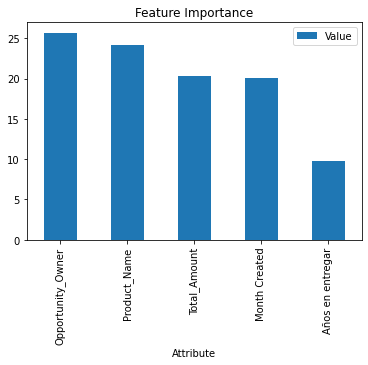

In [20]:
featureImportance.set_index("Attribute").sort_values(by = "Value", ascending = False).plot.bar(title = "Feature Importance")

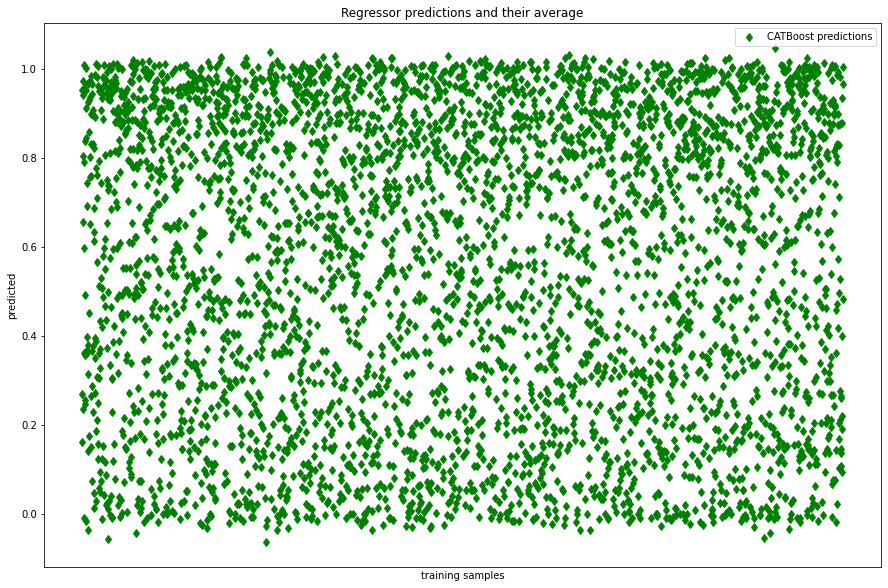

In [38]:

plt.figure(figsize=(15,10))
plt.plot(preds, 'gd', label='CATBoost predictions')


plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')


plt.show()

# Predicciones sobre el test de Kaggle

In [26]:
DataFrame_test = pd.read_csv( "../Test/Test.csv" )

In [27]:
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = DataFrame_test['Total_Amount']*0.0096
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.17
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] 
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'AUD', 'Total_Taxable_Amount'] = DataFrame_test['Total_Amount']*0.70
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'AUD', 'Total_Taxable_Amount_Currency'] = 'USD'

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.29
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

DataFrame_test['Opportunity_Created_Date'] = pd.to_datetime(DataFrame_test['Opportunity_Created_Date'],errors='coerce')

DataFrame_test["Year Created"] = DataFrame_test["Opportunity_Created_Date"].dt.year
DataFrame_test["Month Created"] =DataFrame_test["Opportunity_Created_Date"].dt.month
DataFrame_test["Expensive"] = np.where(DataFrame_test["Total_Amount"] >= 80000, 1, 0)


DataFrame_test = DataFrame_test.merge(entrenamiento_won_by_region, on = "Region")
DataFrame_test["Años en entregar"] = DataFrame_test["Delivery_Year"] - DataFrame_test["Year Created"]


In [28]:
DataFrame_test["Total_Amount"] = np.log(DataFrame_test["Total_Amount"])
DataFrame_test = DataFrame_test[['Opportunity_ID', "Total_Amount", "Años en entregar","Month Created", "Product_Name", "Opportunity_Owner"]]
DataFrame_test = DataFrame_test.drop_duplicates('Opportunity_ID',keep = 'first')
DataFrame_test.set_index('Opportunity_ID', inplace = True)
DataFrame_test["Product_Name"] = DataFrame_test["Product_Name"].map(mean_encoded_product)
DataFrame_test["Opportunity_Owner"] = DataFrame_test["Opportunity_Owner"].map(mean_encoded_owner)

In [29]:
DataFrame_test["Product_Name"].fillna(mean_encoded_product["Other"], inplace = True)
DataFrame_test["Opportunity_Owner"].fillna(mean_encoded_owner["Other"], inplace = True)

# Predicciones

In [30]:
preds = model.predict(DataFrame_test)

In [31]:
subir = pd.DataFrame()
subir['Opportunity_ID'] = DataFrame_test.reset_index()['Opportunity_ID']
subir['target'] = preds
subir.sort_values('Opportunity_ID',inplace = True)
subir = subir.drop_duplicates('Opportunity_ID',keep = 'last')
subir.set_index('Opportunity_ID', inplace = True)
subir

,target
Opportunity_ID,
10689,0.499244
10690,0.525766
10691,0.304772
10692,0.407281
10693,0.907067
...,...
12364,0.974186
12365,0.207168
12366,0.137903


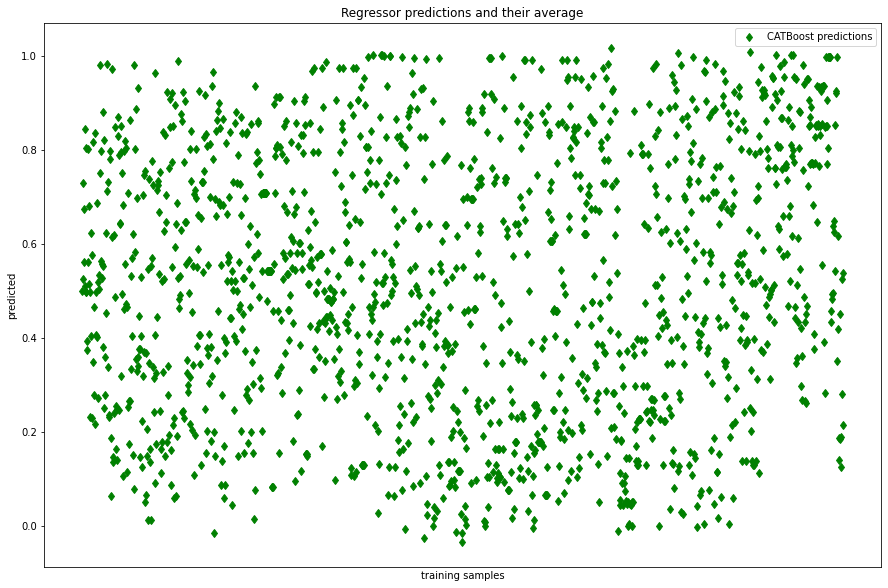

In [36]:

plt.figure(figsize=(15,10))
plt.plot(preds, 'gd', label='CATBoost predictions')


plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')


plt.show()